# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import requests

from PIL import Image
import io
from io import BytesIO
from glob import glob
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler


# Data preprocessing

In [2]:
xml_example='./training_images/cucumber_1.xml'
with open(xml_example, 'r') as f:
    data=f.read()
    content=BeautifulSoup(data, 'xml')
    
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single cucumber</folder>
<filename>cucumber_1.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single cucumber\cucumber_1.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cucumber</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>23</xmin>
<ymin>42</ymin>
<xmax>206</xmax>
<ymax>199</ymax>
</bndbox>
</object>
</annotation>

In [3]:
xml_path=sorted(glob('./training_images/*.xml'))

y=[]

for path in xml_path:
    
    label=0
    info=xt.parse(path)
    root=info.getroot()
    obj=root.find('object')
    label_obj=(obj.find('name').text)
    
    if 'cucumber' in label_obj:
        label=1
        
    elif 'eggplant' in label_obj:
        label=2
    
    elif 'mushroom' in label_obj:
        label=3
        
    bndbox=obj.find('bndbox')
    xmin=(bndbox.find('xmin').text)
    xmax=(bndbox.find('xmax').text)
    ymin=(bndbox.find('ymin').text)
    ymax=(bndbox.find('ymax').text)
    y.append([int(label), int(xmin), int(xmax), int(ymin), int(ymax)])
    
    

In [4]:
x=[]

image_path=sorted(glob('./training_images/*jpg'))

for path in image_path:
    
    image=cv2.imread(path, cv2.COLOR_RGB2BGR)
    x.append(image)


In [ ]:
example_image=x[50]
bbox=y[50][1:]
figure=px.imshow(example_image)
figure.update_layout(width=800, height=600, margin=dict(l=10, r=10, b=10, t=10))
figure.add_shape(type='rect', x0=bbox[0], x1=bbox[1], y0=bbox[2], y1=bbox[3], xref='x', yref='y', line_color='blue')

In [6]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2)

In [7]:
y_train_label=(np.array(y_train)[:, 0:1])
y_train_bbox=(np.array(y_train)[:, 1:])
y_test_label=(np.array(y_test)[:, 0:1])
y_test_bbox=(np.array(y_test)[:, 1:])
print(y_test_label.shape)

(38, 1)


In [8]:
y_train_label=tf.keras.utils.to_categorical(y_train_label)
y_test_label=tf.keras.utils.to_categorical(y_test_label)
x_train=np.array(x_train)
x_test=np.array(x_test)
print(y_test_label.shape)
print(y_train_label.shape)

(38, 4)
(148, 4)


# Model

In [9]:
inception=tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(227,227,3))
inception.trainable=True
last_layer=inception.get_layer('mixed10')
last_layer_output=last_layer.output
x=Flatten()(last_layer_output)
x=Dropout(0.4)(x)
x=Dense(4112, activation='relu')(x)
classification_output=Dense(4, activation='softmax', name='classification')(x)
bounding_box_output=Dense(4, name='bounding_box')(x)
model=Model(inputs=inception.inputs, outputs=[classification_output, bounding_box_output])


In [10]:
def scheduler(epochs, lr):
    
    if epochs<70:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
    
callback=LearningRateScheduler(scheduler)

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-3),
             loss={'classification':'categorical_crossentropy',
                   'bounding_box':'mse'
             },
              metrics={'classification':'accuracy',
                       'bounding_box':'mse'
                  
              }
             )

In [12]:
print(y_train_label.shape, y_train_bbox.shape, y_test_label.shape, y_test_bbox.shape)

(148, 4) (148, 4) (38, 4) (38, 4)


In [13]:
r=model.fit(x_train, [y_train_label, y_train_bbox],  epochs=150, validation_data=(x_test, [y_test_label, y_test_bbox]), callbacks=[callback])

Epoch 1/150
5/5 [==============================] - 37s 6s/step - loss: 11586.6895 - classification_loss: 9.0080 - bounding_box_loss: 11577.6826 - classification_accuracy: 0.2905 - bounding_box_mse: 11577.6826 - val_loss: 3886.8066 - val_classification_loss: 27.1061 - val_bounding_box_loss: 3859.7007 - val_classification_accuracy: 0.3684 - val_bounding_box_mse: 3859.7007 - lr: 0.0010
Epoch 2/150
5/5 [==============================] - 30s 6s/step - loss: 1461.3105 - classification_loss: 16.1476 - bounding_box_loss: 1445.1630 - classification_accuracy: 0.3446 - bounding_box_mse: 1445.1630 - val_loss: 5134.3076 - val_classification_loss: 6.2049 - val_bounding_box_loss: 5128.1030 - val_classification_accuracy: 0.2895 - val_bounding_box_mse: 5128.1030 - lr: 0.0010
Epoch 3/150
5/5 [==============================] - 29s 6s/step - loss: 952.2852 - classification_loss: 9.3579 - bounding_box_loss: 942.9272 - classification_accuracy: 0.2635 - bounding_box_mse: 942.9272 - val_loss: 1116.5762 - val_

Epoch 23/150
5/5 [==============================] - 28s 6s/step - loss: 132.5661 - classification_loss: 1.0312 - bounding_box_loss: 131.5349 - classification_accuracy: 0.6554 - bounding_box_mse: 131.5349 - val_loss: 810.1917 - val_classification_loss: 1.8852 - val_bounding_box_loss: 808.3066 - val_classification_accuracy: 0.4211 - val_bounding_box_mse: 808.3066 - lr: 0.0010
Epoch 24/150
5/5 [==============================] - 25s 5s/step - loss: 102.7478 - classification_loss: 0.6602 - bounding_box_loss: 102.0876 - classification_accuracy: 0.7568 - bounding_box_mse: 102.0876 - val_loss: 540.3849 - val_classification_loss: 1.4425 - val_bounding_box_loss: 538.9425 - val_classification_accuracy: 0.4474 - val_bounding_box_mse: 538.9425 - lr: 0.0010
Epoch 25/150
5/5 [==============================] - 25s 5s/step - loss: 103.2765 - classification_loss: 0.6132 - bounding_box_loss: 102.6633 - classification_accuracy: 0.7635 - bounding_box_mse: 102.6633 - val_loss: 482.2261 - val_classification_

Epoch 45/150
5/5 [==============================] - 28s 6s/step - loss: 64.9437 - classification_loss: 0.4883 - bounding_box_loss: 64.4554 - classification_accuracy: 0.7905 - bounding_box_mse: 64.4554 - val_loss: 138.0162 - val_classification_loss: 1.6955 - val_bounding_box_loss: 136.3207 - val_classification_accuracy: 0.4211 - val_bounding_box_mse: 136.3207 - lr: 0.0010
Epoch 46/150
5/5 [==============================] - 28s 6s/step - loss: 77.8175 - classification_loss: 0.8074 - bounding_box_loss: 77.0100 - classification_accuracy: 0.7297 - bounding_box_mse: 77.0100 - val_loss: 130.1127 - val_classification_loss: 0.5463 - val_bounding_box_loss: 129.5664 - val_classification_accuracy: 0.8158 - val_bounding_box_mse: 129.5664 - lr: 0.0010
Epoch 47/150
5/5 [==============================] - 28s 6s/step - loss: 85.8742 - classification_loss: 0.9532 - bounding_box_loss: 84.9210 - classification_accuracy: 0.6622 - bounding_box_mse: 84.9210 - val_loss: 202.5329 - val_classification_loss: 0.9

Epoch 67/150
5/5 [==============================] - 29s 6s/step - loss: 50.5509 - classification_loss: 0.3259 - bounding_box_loss: 50.2250 - classification_accuracy: 0.8851 - bounding_box_mse: 50.2250 - val_loss: 106.6515 - val_classification_loss: 0.2892 - val_bounding_box_loss: 106.3623 - val_classification_accuracy: 0.8158 - val_bounding_box_mse: 106.3623 - lr: 0.0010
Epoch 68/150
5/5 [==============================] - 30s 6s/step - loss: 52.6550 - classification_loss: 0.1469 - bounding_box_loss: 52.5081 - classification_accuracy: 0.9459 - bounding_box_mse: 52.5081 - val_loss: 148.8953 - val_classification_loss: 0.5932 - val_bounding_box_loss: 148.3022 - val_classification_accuracy: 0.7632 - val_bounding_box_mse: 148.3022 - lr: 0.0010
Epoch 69/150
5/5 [==============================] - 32s 6s/step - loss: 74.0258 - classification_loss: 0.2051 - bounding_box_loss: 73.8207 - classification_accuracy: 0.9054 - bounding_box_mse: 73.8207 - val_loss: 105.8589 - val_classification_loss: 0.5

Epoch 89/150
5/5 [==============================] - 28s 6s/step - loss: 11.5465 - classification_loss: 0.1006 - bounding_box_loss: 11.4459 - classification_accuracy: 0.9730 - bounding_box_mse: 11.4459 - val_loss: 98.5660 - val_classification_loss: 0.3338 - val_bounding_box_loss: 98.2321 - val_classification_accuracy: 0.8421 - val_bounding_box_mse: 98.2321 - lr: 1.4957e-04
Epoch 90/150
5/5 [==============================] - 28s 6s/step - loss: 10.6679 - classification_loss: 0.0775 - bounding_box_loss: 10.5904 - classification_accuracy: 0.9797 - bounding_box_mse: 10.5904 - val_loss: 97.3668 - val_classification_loss: 0.3396 - val_bounding_box_loss: 97.0272 - val_classification_accuracy: 0.8421 - val_bounding_box_mse: 97.0272 - lr: 1.3534e-04
Epoch 91/150
5/5 [==============================] - 28s 6s/step - loss: 17.5545 - classification_loss: 0.0719 - bounding_box_loss: 17.4826 - classification_accuracy: 0.9865 - bounding_box_mse: 17.4826 - val_loss: 96.6381 - val_classification_loss: 0.

Epoch 111/150
5/5 [==============================] - 31s 6s/step - loss: 14.0844 - classification_loss: 0.0752 - bounding_box_loss: 14.0092 - classification_accuracy: 0.9865 - bounding_box_mse: 14.0092 - val_loss: 97.3479 - val_classification_loss: 0.3557 - val_bounding_box_loss: 96.9922 - val_classification_accuracy: 0.8684 - val_bounding_box_mse: 96.9922 - lr: 1.6573e-05
Epoch 112/150
5/5 [==============================] - 29s 6s/step - loss: 12.0718 - classification_loss: 0.0672 - bounding_box_loss: 12.0046 - classification_accuracy: 0.9932 - bounding_box_mse: 12.0046 - val_loss: 97.3133 - val_classification_loss: 0.3554 - val_bounding_box_loss: 96.9579 - val_classification_accuracy: 0.8684 - val_bounding_box_mse: 96.9579 - lr: 1.4996e-05
Epoch 113/150
5/5 [==============================] - 30s 6s/step - loss: 11.2434 - classification_loss: 0.0610 - bounding_box_loss: 11.1824 - classification_accuracy: 0.9932 - bounding_box_mse: 11.1824 - val_loss: 97.7466 - val_classification_loss:

Epoch 133/150
5/5 [==============================] - 26s 5s/step - loss: 10.1095 - classification_loss: 0.0668 - bounding_box_loss: 10.0426 - classification_accuracy: 0.9865 - bounding_box_mse: 10.0426 - val_loss: 99.2833 - val_classification_loss: 0.3469 - val_bounding_box_loss: 98.9364 - val_classification_accuracy: 0.8684 - val_bounding_box_mse: 98.9364 - lr: 1.8363e-06
Epoch 134/150
5/5 [==============================] - 26s 5s/step - loss: 9.9687 - classification_loss: 0.0712 - bounding_box_loss: 9.8975 - classification_accuracy: 0.9865 - bounding_box_mse: 9.8975 - val_loss: 99.3379 - val_classification_loss: 0.3459 - val_bounding_box_loss: 98.9920 - val_classification_accuracy: 0.8684 - val_bounding_box_mse: 98.9920 - lr: 1.6616e-06
Epoch 135/150
5/5 [==============================] - 25s 5s/step - loss: 10.2691 - classification_loss: 0.0666 - bounding_box_loss: 10.2025 - classification_accuracy: 0.9932 - bounding_box_mse: 10.2025 - val_loss: 99.3373 - val_classification_loss: 0.

In [14]:
r.history.keys()

dict_keys(['loss', 'classification_loss', 'bounding_box_loss', 'classification_accuracy', 'bounding_box_mse', 'val_loss', 'val_classification_loss', 'val_bounding_box_loss', 'val_classification_accuracy', 'val_bounding_box_mse', 'lr'])

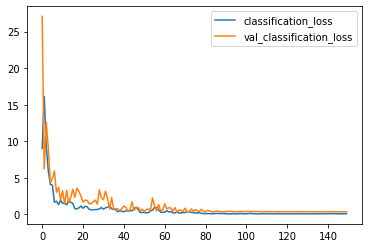

In [15]:
plt.plot(r.history['classification_loss'], label='classification_loss')
plt.plot(r.history['val_classification_loss'], label='val_classification_loss')
plt.legend()



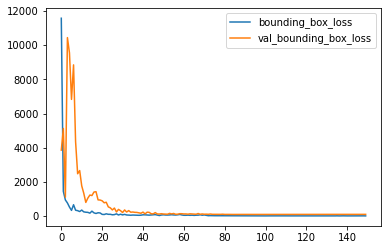

In [16]:
plt.plot(r.history['bounding_box_loss'], label='bounding_box_loss')
plt.plot(r.history['val_bounding_box_loss'], label='val_bounding_box_loss')
plt.legend()



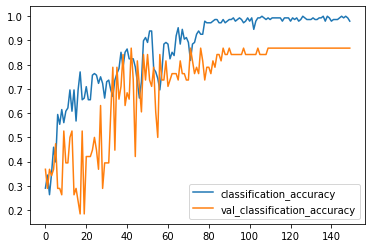

In [17]:
plt.plot(model.history.history['classification_accuracy'], label='classification_accuracy')
plt.plot(model.history.history['val_classification_accuracy'], label='val_classification_accuracy')
plt.legend()

# Evaluation

In [177]:
from urllib.request import urlopen
def prediction(path, model, from_url=False):
   
    if from_url:
        response = requests.get(path)
        image = io.BytesIO(response.content)
        image = Image.open(image)
        image=np.asarray(image)
        
        
    else:
        image = cv2.imread(path)
        
    image = cv2.resize(image,(227,227))
    categ,bbox = model.predict(np.array([image]))
    categ = np.argmax(categ)
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    image = cv2.rectangle(image,(bbox[0], bbox[2]),(bbox[1], bbox[3]),(255,0,0),1)
    prediction = ''
    if categ == 1:
        prediction = 'Cucumber'
    elif categ == 2:
        prediction = 'Egg Plant'
    elif categ == 3:
        prediction = 'Mushroom'
    final_img = cv2.putText(image,prediction,(bbox[0],bbox[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    plt.imshow(final_img)
    
   


1/1 [==============================] - 0s 110ms/step


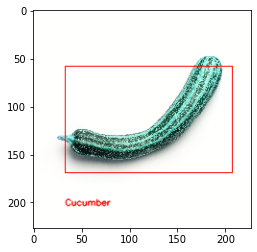

In [178]:
prediction('mockup-graphics-k5WO5dCp5MI-unsplash (1).jpg', model)


1/1 [==============================] - 0s 116ms/step


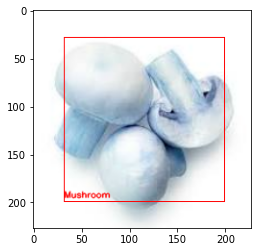

In [179]:
prediction('images.jpg', model)

1/1 [==============================] - 0s 119ms/step


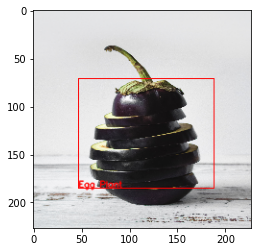

In [180]:
prediction('https://unsplash.com/photos/V8yINTK-bos/download?ixid=MnwxMjA3fDB8MXxjb2xsZWN0aW9ufDV8MExONXVfNEZaYjh8fHx8fDJ8fDE2NjgxOTA0NTU&force=true', model, from_url=True)

1/1 [==============================] - 0s 125ms/step


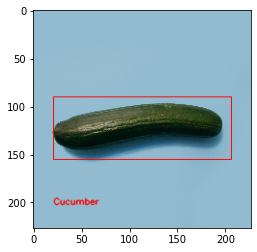

In [183]:
prediction('https://unsplash.com/photos/aLUrTZE7zTo/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fGN1Y3VtYmVyfGVufDB8fHx8MTY2ODE0Mjk1OA&force=true', model, from_url=True)